<a href="https://colab.research.google.com/github/matheusmopucrs/Aprendizado-de-Maquina/blob/main/ML_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import shap

# **Carregando dataset**

In [ ]:
# Set the path to the file you'd like to load
file_path = "players_data-2024_2025.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "hubertsidorowicz/football-players-stats-2024-2025",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

Using Colab cache for faster access to the 'football-players-stats-2024-2025' dataset.
First 5 records:    Rk             Player   Nation    Pos        Squad                Comp  \
0   1         Max Aarons  eng ENG     DF  Bournemouth  eng Premier League   
1   2         Max Aarons  eng ENG  DF,MF     Valencia          es La Liga   
2   3     Rodrigo Abajas   es ESP     DF     Valencia          es La Liga   
3   4     James Abankwah   ie IRL  DF,MF      Udinese          it Serie A   
4   5  Keyliane Abdallah   fr FRA     FW    Marseille          fr Ligue 1   

    Age    Born  MP  Starts  ...  Att (GK)  Thr  Launch%  AvgLen  Opp  Stp  \
0  24.0  2000.0   3       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
1  24.0  2000.0   4       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
2  21.0  2003.0   1       1  ...       NaN  NaN      NaN     NaN  NaN  NaN   
3  20.0  2004.0   6       0  ...       NaN  NaN      NaN     NaN  NaN  NaN   
4  18.0  2006.0   1       0  ...       NaN 

In [ ]:
# Exibir informações gerais sobre os dados
print("\nInformações do Conjunto de Treino:")
df.info()

# Verificar a distribuição das classes (balanceamento)
print("\nDistribuição das Classes:")
print(df['Pos'].value_counts())


Informações do Conjunto de Treino:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2854 entries, 0 to 2853
Columns: 267 entries, Rk to AvgDist
dtypes: float64(111), int64(121), object(35)
memory usage: 5.8+ MB

Distribuição das Classes:
Pos
DF       859
MF       589
FW       371
FW,MF    325
MF,FW    230
GK       212
DF,MF    110
MF,DF     81
DF,FW     53
FW,DF     24
Name: count, dtype: int64


#**Limpando o dataset**

In [ ]:
#Numero de jogadores antes da limpeza
print(f"Numero de jogadores antes da limpeza: {len(df)}")

df_final= df.copy()

#Removendo os jogadores com a posição GOL
df_final = df_final[df_final['Pos'] != 'GK'].copy()

#Removendo as posições secundarias
df_final['Pos'] = df_final['Pos'].str.split(',').str[0]

#Removendo jogadores que tiveram minutagem baixa
df_final = df_final[df_final['90s'] >= 10].copy()

print(df_final['Pos'].value_counts())
print(f"Numero de jogadores depois da limpeza: {len(df_final)}")

Numero de jogadores antes da limpeza: 2854
Pos
DF    618
MF    492
FW    343
Name: count, dtype: int64
Numero de jogadores depois da limpeza: 1453


# **Escolhendo as features**

In [ ]:
colunas_selecionadas = [
    '90s',    #Minutos dividos por 90
    'Gls',    #gols (FW)
    'xG',     #Gols esperados(FW)
    'Ast',    #assistencias (FW, MF)
    'xAG',    #Assistencias esperadas (FW, MF)
    'Tkl',    #Botes(DF, MF)
    'TklW',   #Botes certos(DF, MF)
    'Blocks', #Bloqueios(DF, MF)
    'Int',    #Interceptações(DF, MF)
    'Clr',    #Clearences(DF)
    'Recov',  #Bolas recuperadas(MF)
    'Err',    #Erros que levaram ao gol adversario(DF, MF)
    'PKcon',  #Penaltis cometidos(DF)
    #'CrdY',   #Cartões Amarelos(DF, MF)
    #'CrdR',   #Cartões Vermelhos(DF, MF)
    'PrgP',   #Passes progressivos(MF, DF)
    'KP',     #Passes chaves(passes que levaram ao um chute)
    'Att',    #Passes tentados ou dribles tentados?
    'Cmp',    #Passes completados(DF, MF)
    'Cmp%',   #Porcentagem de passes completados(DF, MF)
    'PPA',    #Passes em direção a area do penalti
    'Live',   #Passes com bola rolando(MF, DF)
    'SCA',      #Shot-Creation Actions(MF, FW)
    'Touches',  #Toques na bola(MF, DF)
    'Carries',  #Total ball carries(DF, MF)
    'PrgC',     #Progressive Carries(FW, MF)
    'CPA',      #Carries into penalty area(FW, MF)
    'TB',       #Bolas lançadas por tras de defensores(MF, FW)
    'Rec',    #Numero de vezes que o jogador recebeu a bola(MF, DF)
    'PrgR',    #Numero de vezes que o jogador recebeu um passe progressivo(FW, MF)
    'Mis',    #Miscontrols(FW, MF)
    'Dis',    #Times dispossessed(FW, MF)
    'Succ',   #Dribles completados(FW, MF)
    'Tkld',    #Numero de vezes que foi tentado ser desarmado durante uma tentativa de drible(FW)
    'Sh',     #Chutes totais(FW, MF)
    'SoT',    #Chutes ao gol(FW, MF)
    'PrgDist',  #Distancia que o jogador levou a bola em direção ao gol(DF, MF)
    'TotDist',  #Distancia que o jogador levou a bola em qualquer direção(MF, DF)
    'Fls',    #Faltas cometidas
    'Fld',    #Faltas sofridas(MF, FW)
    'Off',    #Impedimentos(FW)
    'Crs',    #Cruzamentos
    'TI',     #Laterais(DF)
    #'OG',     #Gols contras
    'Att Pen',  #Toques dentro da area do penalti adversaria(FW)
    'Def Pen',  #Toques dentro da area do penalti aliada(DF)
    'Def 3rd',  #Touches in defensive 1/3 (DF)
    'Mid 3rd',  #Touches in mid 1/3 (MF, DF)
    'Att 3rd',  #Touches in attacking 1/3 (FW, MF)
    'Pos'     #Posição(atributo alvo)
]

df_final = df_final[colunas_selecionadas].copy()

# **Normalizar os dados em relação aos minutos jogados**

In [ ]:
stats_normalizar = [
    coluna for coluna in colunas_selecionadas if coluna != '90s' and coluna != 'Pos'
]

for stat in stats_normalizar:
    novo_nome_coluna = f'{stat}/90s'
    df_final[novo_nome_coluna] = df_final[stat] / df_final['90s']

colunas_manter =  ['Pos'] + [f'{stat}/90s' for stat in stats_normalizar]

#Remover colunas não normalizadas
df_final = df_final[colunas_manter].copy()
#Printar todas as colunas
print(df_final.columns)

Index(['Pos', 'Gls/90s', 'xG/90s', 'Ast/90s', 'xAG/90s', 'Tkl/90s', 'TklW/90s',
       'Blocks/90s', 'Int/90s', 'Clr/90s', 'Recov/90s', 'Err/90s', 'PKcon/90s',
       'PrgP/90s', 'KP/90s', 'Att/90s', 'Cmp/90s', 'Cmp%/90s', 'PPA/90s',
       'Live/90s', 'SCA/90s', 'Touches/90s', 'Carries/90s', 'PrgC/90s',
       'CPA/90s', 'TB/90s', 'Rec/90s', 'PrgR/90s', 'Mis/90s', 'Dis/90s',
       'Succ/90s', 'Tkld/90s', 'Sh/90s', 'SoT/90s', 'PrgDist/90s',
       'TotDist/90s', 'Fls/90s', 'Fld/90s', 'Off/90s', 'Crs/90s', 'TI/90s',
       'Att Pen/90s', 'Def Pen/90s', 'Def 3rd/90s', 'Mid 3rd/90s',
       'Att 3rd/90s'],
      dtype='object')


# **Separação e divisão do dataset**

In [ ]:
#Separar x e y

X = df_final.drop('Pos', axis=1)
y = df_final['Pos']

#Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
scaler = StandardScaler()

# Ajusta o scaler APENAS nos dados de treino e os transforma
X_train_scaled = scaler.fit_transform(X_train)

# APLICA a mesma transformação nos dados de teste
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.preprocessing import PowerTransformer

# 1. Crie o transformador
# O método 'yeo-johnson' funciona para dados positivos e negativos.
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

#**RFECV**

Iniciando a seleção de features com RFECV...
Seleção finalizada.
Número ideal de features encontrado: 5


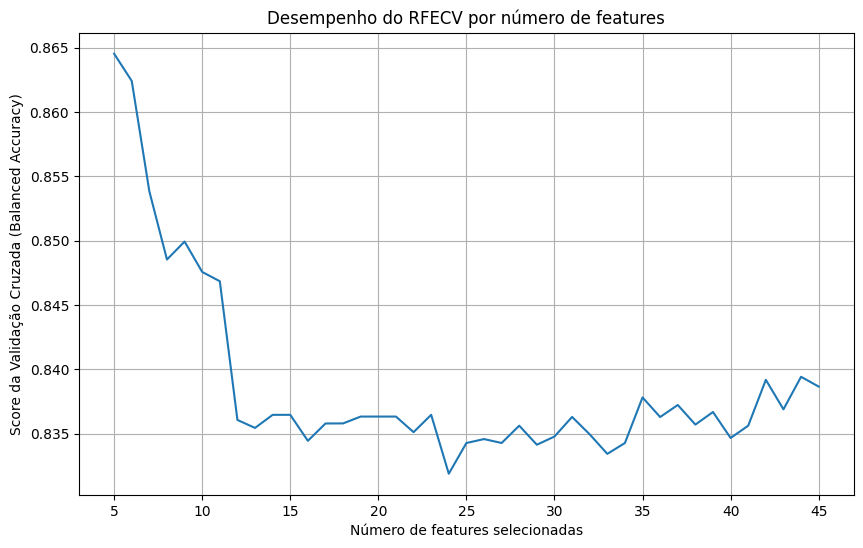

Número ideal de features encontrado: 5
Features selecionadas: ['Clr/90s', 'PrgP/90s', 'Touches/90s', 'TI/90s', 'Att Pen/90s']


In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(max_depth=5, random_state=42)

selector = RFECV(
    estimator=estimator,
    step=1,
    cv=StratifiedKFold(5),
    scoring='balanced_accuracy',
    min_features_to_select=5,
)

print("Iniciando a seleção de features com RFECV...")
selector.fit(X_train_transformed, y_train)
print("Seleção finalizada.")

print(f"Número ideal de features encontrado: {selector.n_features_}")

X_train_final = selector.transform(X_train_transformed)
X_test_final = selector.transform(X_test_transformed)

plt.figure(figsize=(10, 6))
plt.xlabel("Número de features selecionadas")
plt.ylabel("Score da Validação Cruzada (Balanced Accuracy)")
# Em versões mais recentes do scikit-learn, use selector.cv_results_['mean_test_score']
# Se der erro, a versão antiga usa selector.grid_scores_
plt.plot(range(selector.min_features_to_select,
               selector.min_features_to_select + len(selector.cv_results_['mean_test_score'])),
         selector.cv_results_['mean_test_score'])
plt.title("Desempenho do RFECV por número de features")
plt.grid()
plt.show()


# Veja o resultado final
print(f"Número ideal de features encontrado: {selector.n_features_}")
# Corrigido: Acessar os nomes das colunas do DataFrame original 'x_train'
print(f"Features selecionadas: {list(X_train.columns[selector.support_])}")

selected_features = X_train.columns[selector.support_]

# **Modelo 1:KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    # Número de vizinhos a considerar
    'n_neighbors': range(15, 30),

    # Como os votos dos vizinhos são ponderados:
    # 'uniform': todos os vizinhos têm o mesmo peso.
    # 'distance': vizinhos mais próximos têm mais influência.
    'weights': ['uniform', 'distance'],

    'p': [1, 2] # p=1 (Manhattan), p=2 (Euclidiana)
}


grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# 3. Treinar o GridSearchCV com os dados de treino
# Isso vai testar todas as combinações e encontrar a melhor
print("Iniciando GridSearchCV para o KNN...")
grid_knn.fit(X_train_final, y_train)

# 4. Exibir os melhores resultados encontrados
print("\n--- Resultados do GridSearchCV para KNN ---")
print(f"Melhores parâmetros encontrados: {grid_knn.best_params_}")
print(f"Melhor acurácia (validação cruzada): {grid_knn.best_score_:.4f}")

# 5. Avaliar o melhor modelo encontrado nos dados de TESTE
print("\n--- Avaliação final do melhor modelo KNN no conjunto de teste ---")
best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test_final)
print(classification_report(y_test, y_pred_best_knn))

Iniciando GridSearchCV para o KNN...

--- Resultados do GridSearchCV para KNN ---
Melhores parâmetros encontrados: {'n_neighbors': 26, 'p': 2, 'weights': 'distance'}
Melhor acurácia (validação cruzada): 0.8881

--- Avaliação final do melhor modelo KNN no conjunto de teste ---
              precision    recall  f1-score   support

          DF       0.97      0.99      0.98       124
          FW       0.89      0.93      0.91        69
          MF       0.95      0.89      0.92        98

    accuracy                           0.94       291
   macro avg       0.93      0.94      0.93       291
weighted avg       0.94      0.94      0.94       291



  0%|          | 0/291 [00:00<?, ?it/s]

Gerando SHAP Summary Plot para o KNN...


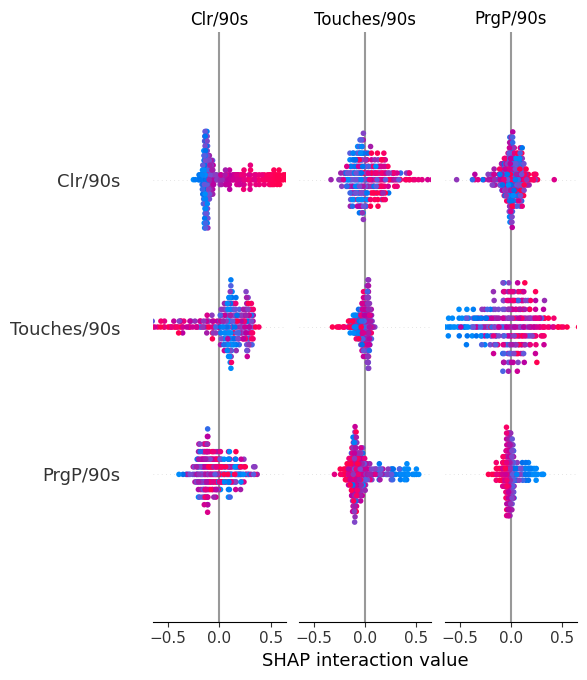

In [ ]:
import shap

# Usaremos o melhor modelo KNN do GridSearch ('best_knn')
# e os dados de treino e teste com features selecionadas e escalados
# X_train_final e X_test_final

# Define selected_features by getting the column names from the original training data
# using the selector.support_ attribute from the RFECV step.
selected_features = X_train.columns[selector.support_]

# 1. Crie um "explainer". Como o KNN não tem um explainer específico no SHAP,
# usamos o KernelExplainer, que funciona para qualquer modelo.
# Usamos um subconjunto dos dados de treino para criar o background (resumo dos dados).
explainer = shap.KernelExplainer(best_knn.predict_proba, shap.sample(X_train_final, 100))

# 2. Calcule os valores SHAP para os dados de teste
shap_values = explainer.shap_values(X_test_final)

# 3. Crie um plot de resumo (summary plot)
# Este é o plot mais importante. Ele mostra a importância de cada feature e
# o impacto dela nas previsões.
print("Gerando SHAP Summary Plot para o KNN...")
shap.summary_plot(shap_values, X_test_final, feature_names=selected_features, class_names=best_knn.classes_)

# **Modelo 2: Árvore de Decisão**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 1. Definir a grade de parâmetros que queremos testar
param_grid_tree = {
    # Profundidade máxima da árvore
    'max_depth': [5, 10, 15],

    # Critério para medir a qualidade da divisão
    'criterion': ['gini', 'entropy'],

    # Número mínimo de amostras necessárias em um nó folha
    'min_samples_leaf': [2, 5, 8],

    # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_split': [2, 5, 8],

    # Número de features a serem consideradas ao procurar a melhor divisão
    'max_features': ['sqrt', 'log2', None]
}

# 2. Instanciar o GridSearchCV
grid_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_tree,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

# 3. Treinar o GridSearchCV
print("Iniciando GridSearchCV para a Árvore de Decisão...")
grid_tree.fit(X_train_final, y_train)

# 4. Exibir os melhores resultados encontrados
print("\n--- Resultados do GridSearchCV para Árvore de Decisão ---")
print(f"Melhores parâmetros encontrados: {grid_tree.best_params_}")
print(f"Melhor acurácia (validação cruzada): {grid_tree.best_score_:.4f}")

# 5. Avaliar o melhor modelo encontrado nos dados de TESTE
print("\n--- Avaliação final da melhor Árvore de Decisão no conjunto de teste ---")
best_tree = grid_tree.best_estimator_
y_pred_best_tree = best_tree.predict(X_test_final)
print(classification_report(y_test, y_pred_best_tree))

Iniciando GridSearchCV para a Árvore de Decisão...

--- Resultados do GridSearchCV para Árvore de Decisão ---
Melhores parâmetros encontrados: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Melhor acurácia (validação cruzada): 0.8830

--- Avaliação final da melhor Árvore de Decisão no conjunto de teste ---
              precision    recall  f1-score   support

          DF       0.97      0.95      0.96       124
          FW       0.89      0.80      0.84        69
          MF       0.83      0.91      0.87        98

    accuracy                           0.90       291
   macro avg       0.90      0.89      0.89       291
weighted avg       0.90      0.90      0.90       291



Importância das Features - Árvore de Decisão:
       Feature  Importance
1      Clr/90s    0.432484
2      Cmp/90s    0.202528
6       TI/90s    0.178137
3     PrgR/90s    0.114925
7  Att Pen/90s    0.028141
5  PrgDist/90s    0.023467
4       Sh/90s    0.014780
0     TklW/90s    0.005538


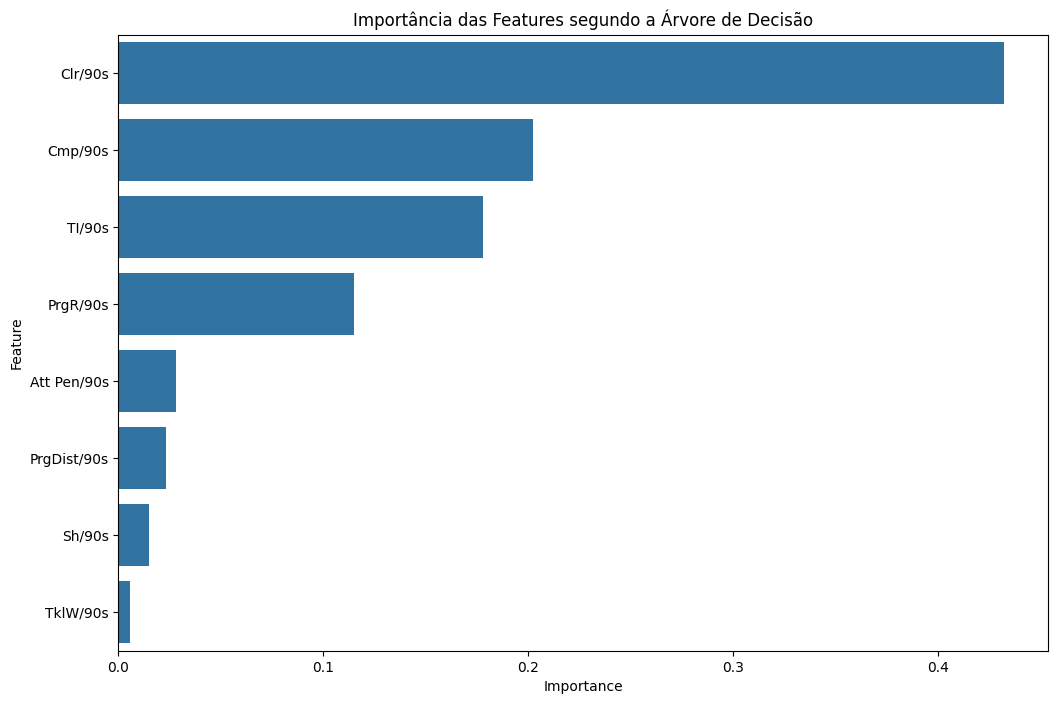

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que 'best_tree' é sua melhor árvore do GridSearchCV
# e 'X_train' é seu dataframe original antes de escalar
selected_features = X_train.columns[selector.support_]

# Extrair a importância
importances = best_tree.feature_importances_

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Importância das Features - Árvore de Decisão:")
print(feature_importance_df)

# Visualizar
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Features segundo a Árvore de Decisão')
plt.show()

# **Visualizar a árvore**

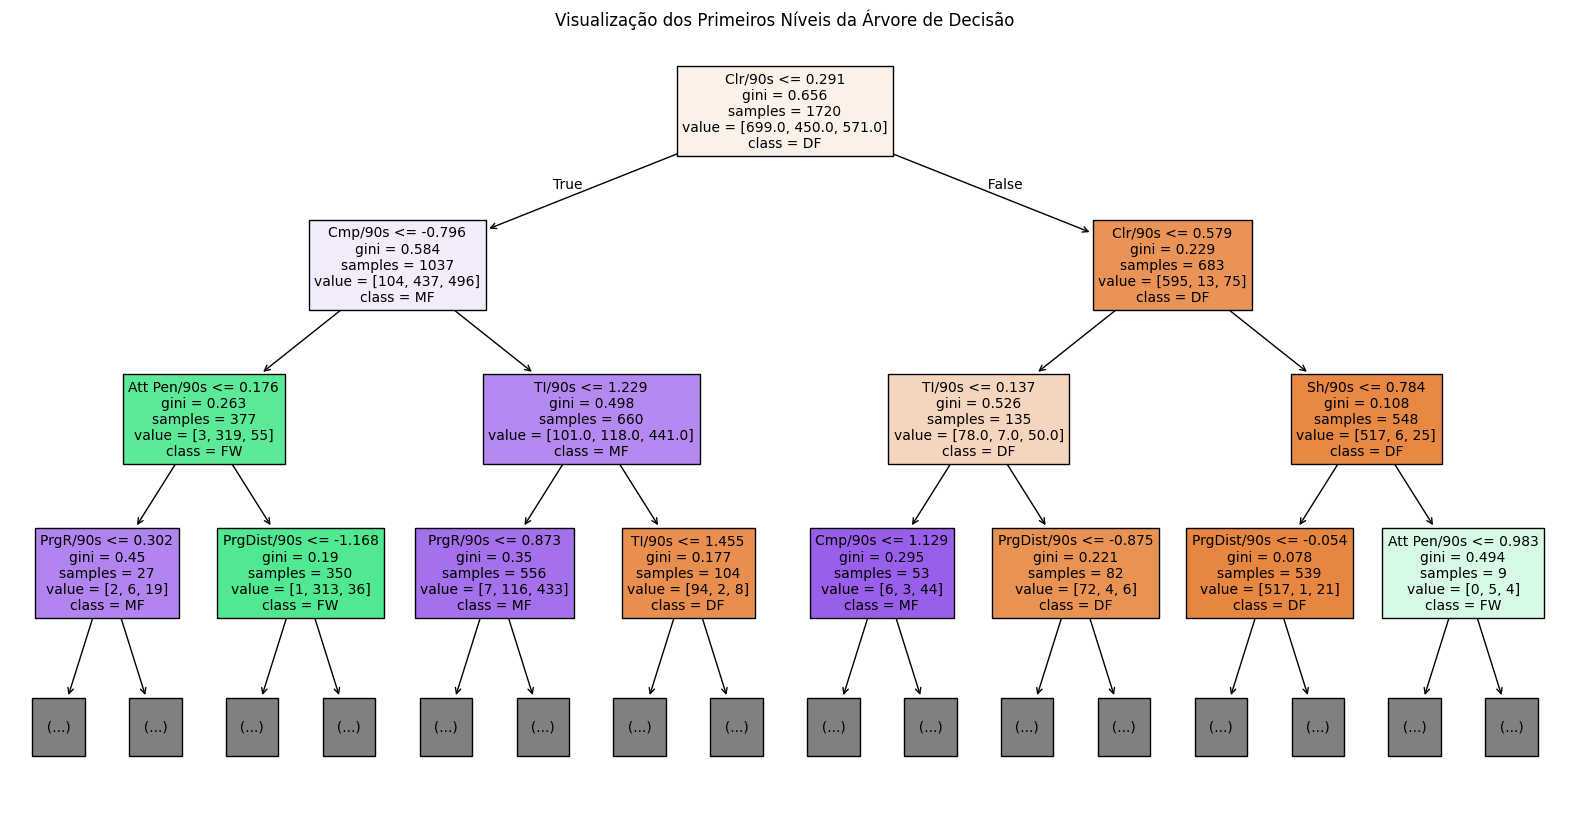

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
# Plotando com profundidade máxima de 3 para ser legível
plot_tree(best_tree, feature_names=selected_features, class_names=best_tree.classes_, filled=True, max_depth=3, fontsize=10)
plt.title("Visualização dos Primeiros Níveis da Árvore de Decisão")
plt.show()

# **Modelo 3: Naive Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB

# --- Treinamento Direto do Naïve Bayes ---
# Este modelo é mais simples e não requer otimização de hiperparâmetros complexos.

# 1. Inicialização do modelo
naive_bayes = GaussianNB()

# 2. Treinamento do modelo
print("Treinando Naïve Bayes...")
naive_bayes.fit(X_train_final, y_train)

# 3. Previsões
y_pred_nb = naive_bayes.predict(X_test_final)

# 4. Avaliação
print("\n--- Resultados para o Naïve Bayes ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_nb):.4f}")
print(classification_report(y_test, y_pred_nb))

Treinando Naïve Bayes...

--- Resultados para o Naïve Bayes ---
Acurácia: 0.8797
              precision    recall  f1-score   support

          DF       0.92      0.96      0.94       124
          FW       0.80      0.93      0.86        69
          MF       0.90      0.74      0.82        98

    accuracy                           0.88       291
   macro avg       0.87      0.88      0.87       291
weighted avg       0.88      0.88      0.88       291



--- Médias das Features por Posição (Naïve Bayes) ---


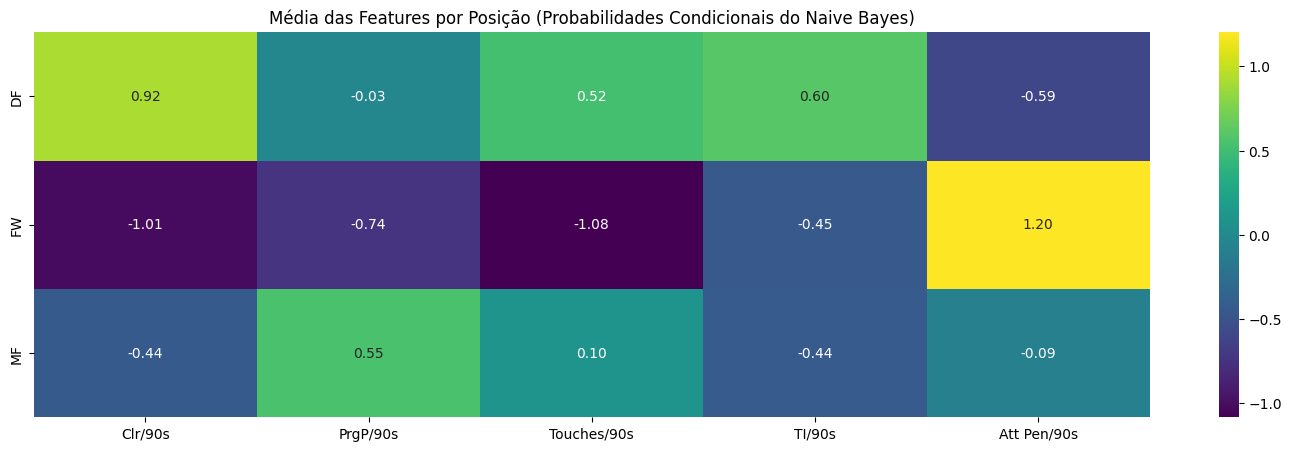

In [ ]:
# Supondo que 'naive_bayes' é seu modelo treinado
# e 'selected_features' são os nomes das colunas selecionadas

# Médias de cada feature para cada classe
means_df = pd.DataFrame(naive_bayes.theta_, columns=selected_features, index=naive_bayes.classes_)

# Variâncias de cada feature para cada classe
variances_df = pd.DataFrame(naive_bayes.var_, columns=selected_features, index=naive_bayes.classes_)

print("--- Médias das Features por Posição (Naïve Bayes) ---")
# Usando um heatmap para facilitar a visualização
plt.figure(figsize=(18, 5))
sns.heatmap(means_df, annot=True, cmap="viridis", fmt=".2f")
plt.title("Média das Features por Posição (Probabilidades Condicionais do Naive Bayes)")
plt.show()

# Analise o heatmap: procure por features que tenham valores médios muito diferentes entre as posições.
# Ex: Você esperaria que 'Def 3rd/90s' tivesse uma média alta para 'DF' (Defensor).

# Comparação de Métricas dos Modelos:

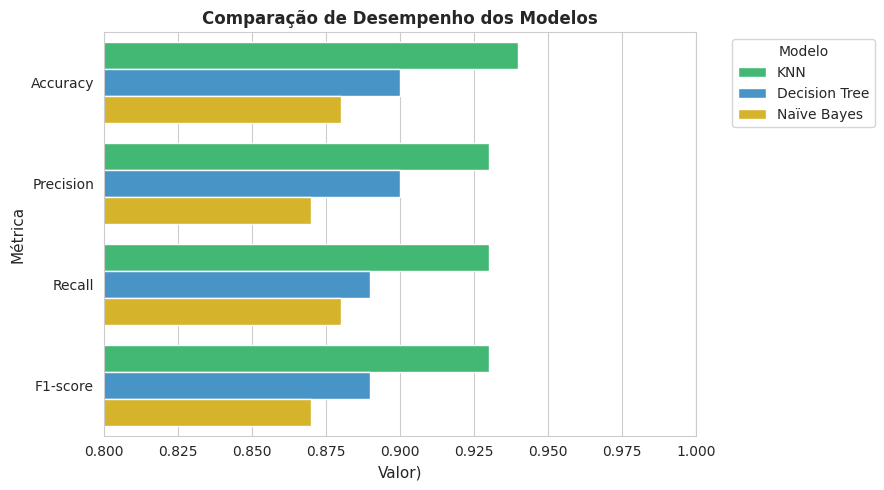

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl

# Definir fonte global
mpl.rcParams['font.family'] = 'Calibri'  # altere para a fonte que preferir

# Dados das métricas
metrics = {
    "KNN": {
        "Accuracy": 0.94,
        "Precision": 0.93,
        "Recall": 0.93,
        "F1-score": 0.93
    },
    "Decision Tree": {
        "Accuracy": 0.90,
        "Precision": 0.90,
        "Recall": 0.89,
        "F1-score": 0.89
    },
    "Naïve Bayes": {
        "Accuracy": 0.88,
        "Precision": 0.87,
        "Recall": 0.88,
        "F1-score": 0.87
    }
}

df_metrics = pd.DataFrame(metrics).T.reset_index().rename(columns={"index": "Modelo"})
df_melt = df_metrics.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

sns.set_style("whitegrid")
plt.figure(figsize=(9,5))

# Paleta personalizada: verde, azul, amarelo
palette = ["#2ecc71", "#3498db", "#f1c40f"]

sns.barplot(
    data=df_melt,
    x="Valor", y="Métrica", hue="Modelo",
    palette=palette
)

plt.title("Comparação de Desempenho dos Modelos", fontsize=12, weight="bold")
plt.xlabel("Valor", fontsize=11)
plt.ylabel("Métrica", fontsize=11)
plt.xlim(0.8, 1.0)
plt.legend(title="Modelo", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Comparação das Precisões por Posição:

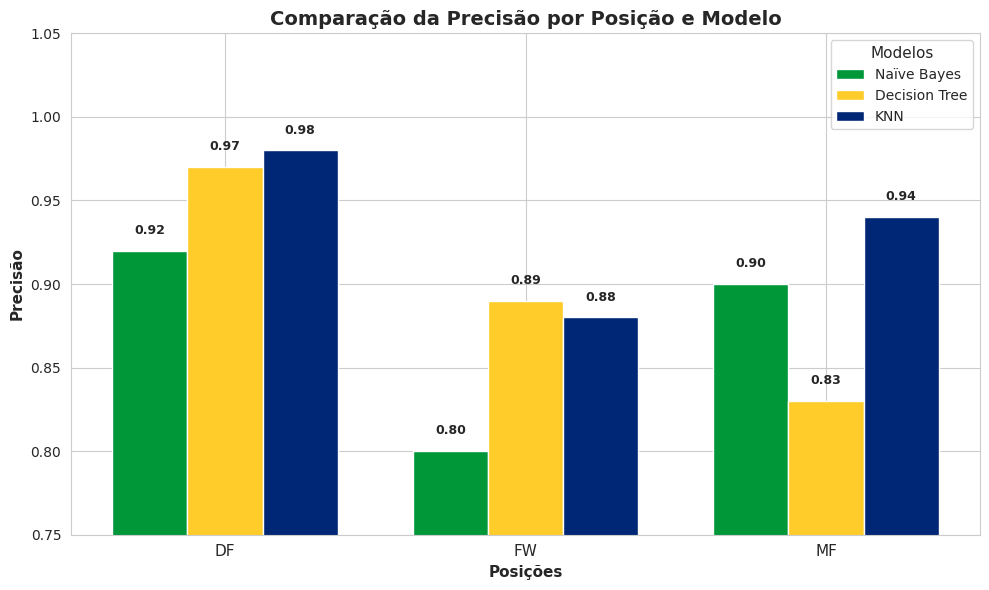

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Dados extraídos dos relatórios
precisions = {
    "Naïve Bayes": {"DF": 0.92, "FW": 0.80, "MF": 0.90},
    "Decision Tree": {"DF": 0.97, "FW": 0.89, "MF": 0.83},
    "KNN": {"DF": 0.98, "FW": 0.88, "MF": 0.94}
}

# Preparar para gráfico
positions = list(precisions["Naïve Bayes"].keys())
models = list(precisions.keys())

# Cores (verde, amarelo, azul)
colors = ["#009739", "#FFCC29", "#002776"]

x = np.arange(len(positions))  # posições no eixo X
width = 0.25  # largura das barras

fig, ax = plt.subplots(figsize=(10,6))

# Criar barras para cada modelo
for i, model in enumerate(models):
    values = list(precisions[model].values())
    ax.bar(x + i*width, values, width, label=model, color=colors[i])

# Personalização
ax.set_ylabel("Precisão", fontsize=11, fontweight="bold")
ax.set_xlabel("Posições", fontsize=11, fontweight="bold")
ax.set_title("Comparação da Precisão por Posição e Modelo", fontsize=14, fontweight="bold")
ax.set_xticks(x + width)
ax.set_xticklabels(positions, fontsize=11)
ax.set_ylim(0.75, 1.05)  # zoom para destacar diferenças
ax.set_yticks(np.arange(0.75, 1.05, 0.05))

# Legenda
ax.legend(title="Modelos", fontsize=10, title_fontsize=11)

# Mostrar valores nas barras
for i, model in enumerate(models):
    values = list(precisions[model].values())
    for j, val in enumerate(values):
        ax.text(x[j] + i*width, val + 0.01, f"{val:.2f}", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.show()
